# Topic Models

### 1. Load libraries and corpora

In [1]:
# Standard library imports
import json
import os
import pandas as pd
import numpy as np
import ast
from bertopic import BERTopic
import spacy
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# from utils import load_corpora_to_df

/var/folders/9j/g3vd45c95dx38zrg1lk6jqwm0000gn/T/ipykernel_3564/537918259.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#####
# 4. Utility Functions for Topic Modeling
#####
    
def load_corpora_to_df(base_dir, subdirs, filter=True):
    """
    Load corpora from specified directories, filtering out documents with less than 100 words,
    and returns a DataFrame with columns for document text, corpus label, and filename.

    Parameters:
    - base_dir: The base directory where the corpora are stored.
    - subdirs: A list of subdirectories inside the base directory.
    - filter: Boolean to indicate whether to filter out documents with less than 100 words.

    Returns:
    - DataFrame with columns 'Document' for the document texts, 'Corpus' for the subdirectory names, and 'Filename' for the names of the files.
    - Dictionary with the count of filtered documents per corpus if filter is True.
    """
    documents = []  # Initialize a list to store (document, corpus, filename) tuples
    filtered_counts = {}  # Dictionary to count filtered documents

    # Iterate through each subdirectory and load documents
    for subdir in subdirs:
        filtered_count = 0  # Reset filtered count for each subdir

        for filename in os.listdir(os.path.join(base_dir, subdir)):
            if filename.endswith('.json'):
                with open(os.path.join(base_dir, subdir, filename), 'r') as file:
                    data = json.load(file)
                    text = data.get('cleaned_text', '')  # Use get to avoid KeyError if 'cleaned_text' does not exist
                    if text:
                        word_count = len(text.split())
                        if filter and word_count >= 100:
                            documents.append((text, subdir, filename))  # Include filename in the tuple
                        elif not filter:
                            documents.append((text, subdir, filename))  # Include filename in the tuple
                        else:
                            filtered_count += 1

        # Update the filtered counts
        filtered_counts[subdir] = filtered_count

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(documents, columns=['Document', 'Corpus', 'Filename'])  # Add 'Filename' to the columns

    return df, filtered_counts


In [4]:
# Set the base directory and subdirectories of the corpora
base_dir = 'documents/preprocessed'
subdirs = ['pseudoscience', 'trusted_sources']

# Load the corpora
corpora_df, filtered_counts = load_corpora_to_df(base_dir, subdirs, filter=False)


In [5]:
corpora_df.head()

,Document,Corpus,Filename
0,"disease. When a patient has HFS, the muscles c...",pseudoscience,NAT214002.json
1,by a science team led by Dr. Robert O. Young. ...,pseudoscience,VCO093069.json
2,The technology to grow fetuses in artificial w...,pseudoscience,VAI305026.json
3,It is a common myth today that the vaccines ad...,pseudoscience,VAS348059.json
4,Connecting the Dots: Forensic computer expert ...,pseudoscience,VCO333026.json


## 2. Create topic models using BERTopic
### 2.1 Without preprocessing

In [6]:
# Create separate embedding model (all-mpnet-base-v2 is a larger model which can be expected to more accurately represent topics)
embedding_model = SentenceTransformer("all-mpnet-base-v2")

#### 2.1.1 Train

In [6]:
# # Create BERTopic model
# bertopic_model = BERTopic(embedding_model=embedding_model, top_n_words=20, calculate_probabilities=True)

# # Fit the model
# topics, probabilities = bertopic_model.fit_transform(corpora_df['Document'])

# # Get the topic info
# topic_info = bertopic_model.get_topic_info()

#### 2.1.2 Save

In [7]:
# # Save the probabilities and topics as nd arrays
# np.save('data/topics/probabilities_20.npy', probabilities)
# np.save('data/topics/topics_20.npy', topics)

# # Save the BERTopic model
# bertopic_model.save("models/BERTopics", serialization="safetensors")

# # Save the topic info
# topic_info.to_csv('data/topics/BERTopic_combined_corpus_20.csv')

#### 2.1.3 Load

In [27]:
# Load the model
bertopic_model = BERTopic.load("models/BERTopics", embedding_model=embedding_model)

# Get the topic info csv
topic_info = pd.read_csv('data/topics/BERTopic_combined_corpus_20.csv', index_col=0)
#Turn "Representation" column from string to list
topic_info['Representation'] = topic_info['Representation'].apply(ast.literal_eval)

# Load topics and probabilities
topics = np.load('data/topics/topics_20.npy')
probabilities = np.load('data/topics/probabilities_20.npy')

2024-03-12 19:53:20,480 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [8]:
# Get topics
document_topics = bertopic_model.topics_

# Append the topics to the original DataFrame
corpora_df['Topic'] = document_topics

# Display
corpora_df.head()

,Document,Corpus,Filename,Topic
0,"disease. When a patient has HFS, the muscles c...",pseudoscience,NAT214002.json,-1
1,by a science team led by Dr. Robert O. Young. ...,pseudoscience,VCO093069.json,169
2,The technology to grow fetuses in artificial w...,pseudoscience,VAI305026.json,407
3,It is a common myth today that the vaccines ad...,pseudoscience,VAS348059.json,-1
4,Connecting the Dots: Forensic computer expert ...,pseudoscience,VCO333026.json,52


### 2.1.4 Get probabilities

In [11]:
# Create a dataframe of the probabilities
probabilities_df = pd.DataFrame(probabilities, columns=topic_info['Name'][1:])

# Round to 4 decimal places
probabilities_df = probabilities_df.round(4)

# Get the indices of the columns that correspond to the largest values in each row
indices_of_largest = np.argsort(-probabilities_df.values, axis=1)

# Create new column that appends column title with argmax of probabilities
probabilities_df['Topic #1'] = probabilities_df.idxmax(axis=1)

# Get the topic names with the largest probabilities (2-5)
for i in range(1,5):
    probabilities_df[f'Topic #{i+1}'] = [probabilities_df.columns[i] for i in indices_of_largest[:, i]]

In [12]:
probabilities_df

Name,0_skin_beauty_acne_skincare,1_climate_warming_temperature_ipcc,2_gm_gmo_crops_gmos,3_evolution_selection_evolutionary_darwin,4_elvis_her_she_his,5_ukraine_russia_russian_ukrainian,6_hpv_gardasil_cervical_merck,7_glyphosate_roundup_monsanto_herbicide,8_homeopathy_homeopathic_homeopaths_hahnemann,9_masks_mask_wearing_face,...,1318_injections_820_columbia_schetters,1319_trump_mobilizing_fucking_trumpcine,1320_movie_contagion_ehle_possession,1321_holiday_holidays_thanksgiving_doni,1322_catholic_pedophilia_charities_abuse,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5
0,0.0002,0.0001,0.0001,0.0002,0.0002,0.0001,0.0001,0.0001,0.0007,0.0001,...,0.0001,0.0001,0.0001,0.0003,0.0002,305_headaches_migraine_migraines_headache,154_pain_xiphoid_shoulder_muscles,1285_posture_neck_disk_williams,236_chiropractic_chiropractors_fascia_chiropra...,153_arthritis_joints_joint_rheumatoid
1,0.0002,0.0003,0.0002,0.0003,0.0003,0.0003,0.0006,0.0002,0.0003,0.0004,...,0.0007,0.0007,0.0006,0.0003,0.0003,169_graphene_oxide_nanoparticles_pfizer,849_graphene_nanobots_oxide_nano,1242_nagase_graphene_carbon_thulium,1188_graphene_oxide_glutathione_emf,438_metallic_lindsay_coronavac_contamination
2,0.0005,0.0006,0.0005,0.0010,0.0011,0.0005,0.0004,0.0005,0.0008,0.0005,...,0.0004,0.0004,0.0005,0.0010,0.0009,407_cloning_embryos_ivf_embryo,1025_chimeras_cloning_embryo_stem,326_crispr_editing_gene_embryos,756_stem_cell_clinics_embryonic,1142_3d_printing_conan_dvir
3,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0005,0.0002,0.0003,0.0004,...,0.0005,0.0005,0.0005,0.0002,0.0002,166_thimerosal_mercury_autism_cdc,771_mercury_autism_thimerosal_hooker,250_thimerosal_mercury_ethylmercury_methylmercury,29_autism_mmr_thimerosal_autistic,1231_homeopathy_hp_homeopathic_allopathic
4,0.0002,0.0003,0.0002,0.0003,0.0005,0.0008,0.0002,0.0002,0.0002,0.0003,...,0.0003,0.0003,0.0004,0.0003,0.0007,52_election_ballots_votes_voting,1299_trump_electoral_election_biden,489_mcdonnell_judge_lawyers_hillary,132_biden_applause_trump_voters,1014_hunter_biden_ymca_shapley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73333,0.0004,0.0008,0.0005,0.0010,0.0017,0.0010,0.0003,0.0004,0.0006,0.0005,...,0.0004,0.0004,0.0005,0.0008,0.0019,331_chatgpt_ai_openai_bing,27_naturalnews_passionately_educating_newstarget,1284_psychosis_wicked_mass_formation,1268_span_annett_zicree_rod,324_ai_intelligence_robots_artificial
73334,0.0007,0.0004,0.0005,0.0005,0.0006,0.0003,0.0003,0.0005,0.0723,0.0003,...,0.0003,0.0003,0.0004,0.0009,0.0005,8_homeopathy_homeopathic_homeopaths_hahnemann,149_homeopathic_homeopathy_fda_medicines,801_prince_charles_ernst_camilla,954_medicine_ozone_naturopathic_alternative,654_acetaminophen_tylenol_paracetamol_generic
73335,0.0008,0.0005,0.0011,0.0007,0.0006,0.0004,0.0003,0.0010,0.0012,0.0003,...,0.0003,0.0003,0.0003,0.0011,0.0005,75_sulphate_calories_eating_eat,99_diet_meat_diets_fat,755_semaglutide_ozempic_wegovy_weight,784_diet_dietary_cholesterol_type,199_infographic_zaatar_ranger_organic
73336,0.0003,0.0004,0.0003,0.0007,0.0008,0.0003,0.0002,0.0003,0.0004,0.0002,...,0.0002,0.0002,0.0002,0.0010,0.0006,63_ayahuasca_ceremony_ceremonies_shaman,1145_nicotine_inca_cigarettes_tobacco,37_psilocybin_psychedelic_psychedelics_dmt,581_pineal_gland_fluoride_melatonin,1038_lodge_sweat_lodges_ray


In [17]:
# Merge corpora_df with the topic columns of probabilities_df 
top_topics_df = pd.concat([corpora_df, probabilities_df], axis=1)

# Drop document column from top_topics_df
top_topics_df = top_topics_df.drop(columns='Document')

# Move columns "topic #1", "topic #2", "topic #3" to the front (but after first 3 columns)
cols = top_topics_df.columns.tolist()
cols = cols[:3] + cols[-3:] + cols[3:-3]
top_topics_df = top_topics_df[cols]

# Rename column "Topic" to "BERTopic Cluster"
top_topics_df = top_topics_df.rename(columns={'Topic': 'BERTopic Cluster'})

In [18]:
# Save to csv
cols = ['Corpus', 'Filename', 'BERTopic Cluster', 'Topic #1', 'Topic #2','Topic #3', 'Topic #4', 'Topic #5']
top_topics_df[cols].to_csv('data/topics/BERTopic_document_probabilities.csv')  

## 3. Evaluation

A few points to note. BERTopic assigns exactly one topic to each document (at least that is the default setting). This might not be accurate, depending on how long the documents are. However, since the median document length for all three corpora is between 600 and 800 words, this does not seem to be a big concern here. Two options would be:
* Just leave the analysis as is
* Exclude documents above a certain length, at which more than one topic could be expected
* Split those documents

### 3.1 Topics related to "vaccination" based on keywords

In [29]:
# Reset the index
topic_info = topic_info.set_index("Topic")

In [30]:
# Find all topics that contain the words "vaccine", "vaccination", "vaxx"
def is_relevant(words_list):
    # Check if any word in the list starts with "vaccin" or "vaxx"
    return any((word.startswith("vaccin")) or (word.startswith("vaxx")) for word in words_list)

topic_info['Relevant_By_Keywords'] = topic_info['Representation'].apply(is_relevant)

In [31]:
topic_info['Representation'].apply(is_relevant).mean() # Percentage of topics that contain word vaccine

0.12462235649546828

In [60]:
topics_vaccine = topic_info[topic_info['Relevant_By_Keywords']]
topics_vaccine.to_csv('data/topics/topics_info_vaccine_keyword.csv')
topics_vaccine

,Count,Name,Representation,Representative_Docs,Relevant_By_Keywords,Relevant_By_Semantics
Topic,,,,,,
6,283,6_hpv_gardasil_cervical_merck,"[hpv, gardasil, cervical, merck, girls, dna, p...",[Every parent desires only the best for their ...,True,False
10,266,10_vaccines_vaccine_vaccination_measles,"[vaccines, vaccine, vaccination, measles, vacc...",[I wanted to share the and transcript for the ...,True,True
26,163,26_children_pfizer_moderna_covid,"[children, pfizer, moderna, covid, 19, age, fd...",[approved booster doses of Pfizer’s COVID-19 v...,True,True
29,156,29_autism_mmr_thimerosal_autistic,"[autism, mmr, thimerosal, autistic, asd, cdc, ...",[November 1937 – Born November 1938 – Vaccinat...,True,False
42,124,42_malone_mrna_gene_moderna,"[malone, mrna, gene, moderna, technology, rna,...","[On February 2, 2023, Robert W. Malone, MD, fi...",True,True
...,...,...,...,...,...,...
1277,11,1277_uh_00_um_bolgan,"[uh, 00, um, bolgan, objects, birkholz, reutli...",[Almost four billion people have them inside t...,True,False
1296,10,1296_walensky_cdc_collins_email,"[walensky, cdc, collins, email, breakthrough, ...",[Authored by Zachary Stieber via The Epoch Tim...,True,False
1305,10,1305_hilali_impeachment_dershowitz_africa,"[hilali, impeachment, dershowitz, africa, rask...",[Morocco claims one of the highest vaccination...,True,False


### 3.2 Topics related to "vaccination" based on semantic similarity in vector space

This method finds the closest topic clusters in vector space to the word-vector representation of "vaccine". Has to be capped, which here is at 50.

In [53]:
# Find similar topics
similar_topics, similarity = bertopic_model.find_topics("vaccine", top_n=150) #165 is number of keyword based relevant topics

# Initialize the new column with False
# topic_info['Relevant_By_Semantics'] = False

for top_n in [100, 125, 150, 175, 200]:
    topic_info[f'Relevant_By_Semantics_{top_n}'] = False
    similar_topics, similarity = bertopic_model.find_topics("vaccine", top_n=top_n)
    topic_info.loc[topic_info.index.isin(similar_topics), f'Relevant_By_Semantics_{top_n}'] = True

# # Set True for rows in similar_topics
# topic_info.loc[topic_info.index.isin(similar_topics), 'Relevant_By_Semantics'] = True

# Show the relevant topics
topic_info[topic_info['Relevant_By_Semantics_200']].head(10)

,Count,Name,Representation,Representative_Docs,Relevant_By_Keywords,Relevant_By_Semantics_4,Relevant_By_Semantics_100,Relevant_By_Semantics_125,Relevant_By_Semantics_150,Relevant_By_Semantics_175,Relevant_By_Semantics_200
Topic,,,,,,,,,,,
-1,25705,-1_was_the_we_of,"[was, the, we, of, he, to, and, that, they, is...",['of .86 percent among the vaccinated and .17 ...,False,True,False,True,True,True,True
6,283,6_hpv_gardasil_cervical_merck,"[hpv, gardasil, cervical, merck, girls, dna, p...",['Every parent desires only the best for their...,True,True,False,True,True,True,True
10,266,10_vaccines_vaccine_vaccination_measles,"[vaccines, vaccine, vaccination, measles, vacc...",['I wanted to share the and transcript for the...,True,True,True,True,True,True,True
26,163,26_children_pfizer_moderna_covid,"[children, pfizer, moderna, covid, 19, age, fd...",['approved booster doses of Pfizer’s COVID-19 ...,True,True,True,True,True,True,True
29,156,29_autism_mmr_thimerosal_autistic,"[autism, mmr, thimerosal, autistic, asd, cdc, ...",['November 1937 – Born November 1938 – Vaccina...,True,True,False,False,True,True,True
42,124,42_malone_mrna_gene_moderna,"[malone, mrna, gene, moderna, technology, rna,...","['On February 2, 2023, Robert W. Malone, MD, f...",True,True,True,True,True,True,True
45,121,45_polio_poliovirus_paralysis_poliomyelitis,"[polio, poliovirus, paralysis, poliomyelitis, ...",['There Was No Polio Virus That Caused Neurolg...,True,True,True,True,True,True,True
47,121,47_covid_vaccines_deaths_vaccinated,"[covid, vaccines, deaths, vaccinated, vaccine,...",['As the data continues to come in regarding t...,True,True,True,True,True,True,True
48,120,48_mrna_rna_dna_moderna,"[mrna, rna, dna, moderna, protein, cells, spik...",['The messenger RNA (mRNA) from Pfizer’s COVID...,True,True,True,True,True,True,True


In [54]:
# Show the relevant topics
topic_info[topic_info['Relevant_By_Keywords']].head(10)

,Count,Name,Representation,Representative_Docs,Relevant_By_Keywords,Relevant_By_Semantics_4,Relevant_By_Semantics_100,Relevant_By_Semantics_125,Relevant_By_Semantics_150,Relevant_By_Semantics_175,Relevant_By_Semantics_200
Topic,,,,,,,,,,,
6,283,6_hpv_gardasil_cervical_merck,"[hpv, gardasil, cervical, merck, girls, dna, p...",['Every parent desires only the best for their...,True,True,False,True,True,True,True
10,266,10_vaccines_vaccine_vaccination_measles,"[vaccines, vaccine, vaccination, measles, vacc...",['I wanted to share the and transcript for the...,True,True,True,True,True,True,True
26,163,26_children_pfizer_moderna_covid,"[children, pfizer, moderna, covid, 19, age, fd...",['approved booster doses of Pfizer’s COVID-19 ...,True,True,True,True,True,True,True
29,156,29_autism_mmr_thimerosal_autistic,"[autism, mmr, thimerosal, autistic, asd, cdc, ...",['November 1937 – Born November 1938 – Vaccina...,True,True,False,False,True,True,True
42,124,42_malone_mrna_gene_moderna,"[malone, mrna, gene, moderna, technology, rna,...","['On February 2, 2023, Robert W. Malone, MD, f...",True,True,True,True,True,True,True
45,121,45_polio_poliovirus_paralysis_poliomyelitis,"[polio, poliovirus, paralysis, poliomyelitis, ...",['There Was No Polio Virus That Caused Neurolg...,True,True,True,True,True,True,True
46,121,46_aluminum_adjuvant_al_aluminium,"[aluminum, adjuvant, al, aluminium, kg, adjuva...",['Click for list of papers in this post. Many ...,True,False,False,False,False,False,False
47,121,47_covid_vaccines_deaths_vaccinated,"[covid, vaccines, deaths, vaccinated, vaccine,...",['As the data continues to come in regarding t...,True,True,True,True,True,True,True
48,120,48_mrna_rna_dna_moderna,"[mrna, rna, dna, moderna, protein, cells, spik...",['The messenger RNA (mRNA) from Pfizer’s COVID...,True,True,True,True,True,True,True


### 3.3 Summary

In [181]:
import numpy as np

# Get overall number of topics
num_topics = len(bertopic_model.get_topics())
print(f"Number of topics: {num_topics}")

# Get number of topics containing "vaccin" or "vaxx"
num_topics = topic_info['Relevant_By_Keywords'].sum()
print(f"Number of topics containing 'vaccin' or 'vaxx': {num_topics}")

# Percentage of topics containing "vaccin" or "vaxx"
percentage_topics = topic_info['Relevant_By_Keywords'].mean()
print(f"Percentage of topics containing 'vaccin' or 'vaxx': {np.round(percentage_topics*100,1)}%")

# Get number of topics semantically similar to "vaccine"
num_topics = topic_info['Relevant_By_Semantics'].sum()
print(f"Number of topics semantically similar to 'vaccine': {num_topics}")

# Percentage of topics semantically similar to "vaccine"
percentage_topics = topic_info['Relevant_By_Semantics'].mean()
print(f"Percentage of topics semantically similar to 'vaccine': {np.round(percentage_topics*100,1)}%")

# Overlap between topics containing "vaccin" or "vaxx" and topics semantically similar to "vaccine"
overlap = topic_info[(topic_info['Relevant_By_Semantics']) & (topic_info['Relevant_By_Keywords'])].shape[0]
print(f"Overlap between topics containing 'vaccin' or 'vaxx' and topics semantically similar to 'vaccine': {overlap}")


Number of topics: 1324
Number of topics containing 'vaccin' or 'vaxx': 165
Percentage of topics containing 'vaccin' or 'vaxx': 12.5%
Number of topics semantically similar to 'vaccine': 150
Percentage of topics semantically similar to 'vaccine': 11.3%
Overlap between topics containing 'vaccin' or 'vaxx' and topics semantically similar to 'vaccine': 88


### 3.4 Probabilities

In [55]:
topic_info['Name'].reset_index(drop=True)

0                                -1_was_the_we_of
1                     0_skin_beauty_acne_skincare
2              1_climate_warming_temperature_ipcc
3                             2_gm_gmo_crops_gmos
4       3_evolution_selection_evolutionary_darwin
                          ...                    
1319       1318_injections_820_columbia_schetters
1320      1319_trump_mobilizing_fucking_trumpcine
1321         1320_movie_contagion_ehle_possession
1322      1321_holiday_holidays_thanksgiving_doni
1323     1322_catholic_pedophilia_charities_abuse
Name: Name, Length: 1324, dtype: object

## 4. Distribution of vaccine related topics across corpora

In [59]:
# Merge with the original DataFrame where topic is a column and in topic_info, Topic is an index
corpora_df = corpora_df[['Document','Filename', 'Corpus', 'Topic']].merge(topic_info, left_on='Topic', right_index=True)
for top_n in [100, 125, 150, 175, 200]:
    corpora_df.loc[0, f'Relevant_By_Semantics_{top_n}'] = False
corpora_df = corpora_df[['Document','Filename', 'Corpus', 'Topic', 'Name', 'Representation','Relevant_By_Keywords','Relevant_By_Semantics_100','Relevant_By_Semantics_125','Relevant_By_Semantics_150','Relevant_By_Semantics_175', 'Relevant_By_Semantics_200']]
corpora_df.head()

,Document,Filename,Corpus,Topic,Name,Representation,Relevant_By_Keywords,Relevant_By_Semantics_100,Relevant_By_Semantics_125,Relevant_By_Semantics_150,Relevant_By_Semantics_175,Relevant_By_Semantics_200
0,"disease. When a patient has HFS, the muscles c...",NAT214002.json,pseudoscience,-1,-1_was_the_we_of,"[was, the, we, of, he, to, and, that, they, is...",False,False,False,False,False,False
1,by a science team led by Dr. Robert O. Young. ...,VCO093069.json,pseudoscience,169,169_graphene_oxide_nanoparticles_pfizer,"[graphene, oxide, nanoparticles, pfizer, micro...",False,False,False,False,False,False
2,The technology to grow fetuses in artificial w...,VAI305026.json,pseudoscience,407,407_cloning_embryos_ivf_embryo,"[cloning, embryos, ivf, embryo, stem, egg, emb...",False,False,False,False,False,False
3,It is a common myth today that the vaccines ad...,VAS348059.json,pseudoscience,-1,-1_was_the_we_of,"[was, the, we, of, he, to, and, that, they, is...",False,False,True,True,True,True
4,Connecting the Dots: Forensic computer expert ...,VCO333026.json,pseudoscience,52,52_election_ballots_votes_voting,"[election, ballots, votes, voting, vote, voter...",False,False,False,False,False,False


In [69]:
# Save to csv
corpora_df[['Filename', 'Corpus', 'Topic', 'Name', 'Representation','Relevant_By_Keywords','Relevant_By_Semantics_100','Relevant_By_Semantics_125','Relevant_By_Semantics_150','Relevant_By_Semantics_175', 'Relevant_By_Semantics_200']].to_csv('data/topics/corpora_topic_assignments.csv')

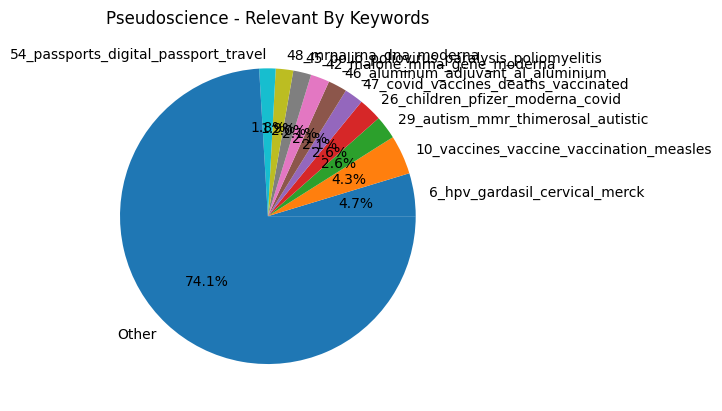

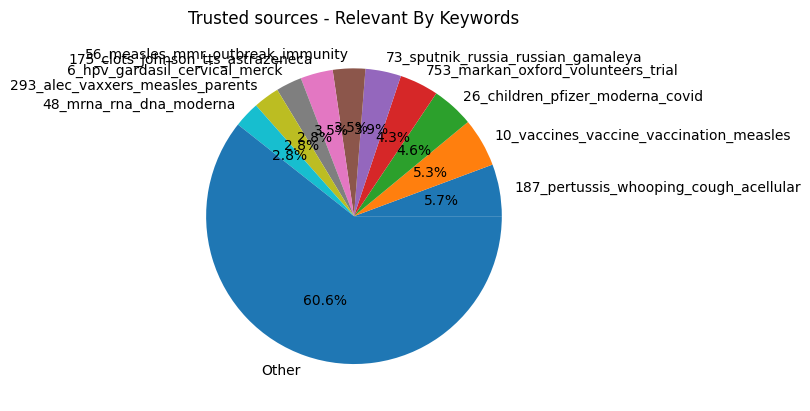

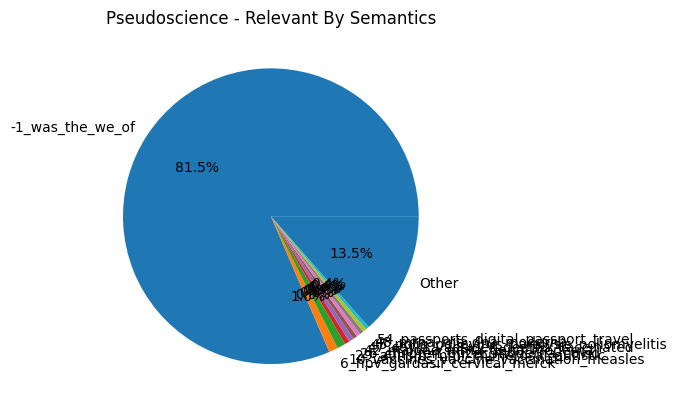

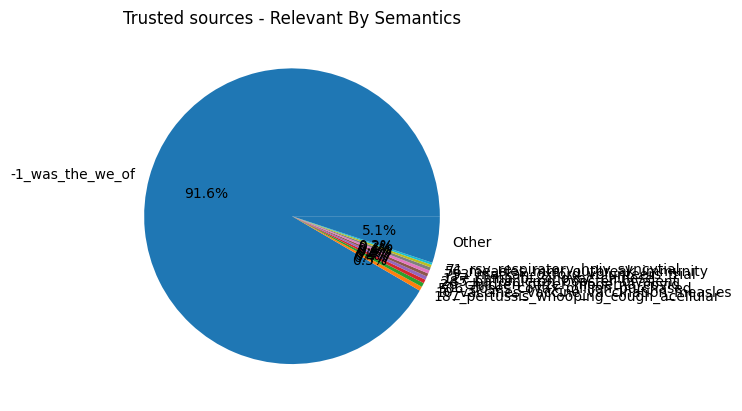

In [184]:
for relevance_measure in ["Relevant_By_Keywords", "Relevant_By_Semantics"]:

    # Split into pseudoscience and trusted sources and filter by relevance measure
    pseudoscience = corpora_df[(corpora_df['Corpus'] == 'pseudoscience') & (corpora_df[relevance_measure])]
    trusted_sources = corpora_df[(corpora_df['Corpus'] == 'trusted_sources') & (corpora_df[relevance_measure])]

    # Get value count on the topic ("Name")
    pseudoscience_topics = pseudoscience['Name'].value_counts(normalize=True)
    trusted_sources_topics = trusted_sources['Name'].value_counts(normalize=True)

    # Get the top 20 topics and name the rest "Other"
    n = 10
    pseudoscience_topics = pseudoscience_topics[:n]
    pseudoscience_topics['Other'] = 1 - pseudoscience_topics.sum()
    trusted_sources_topics = trusted_sources_topics[:n]
    trusted_sources_topics['Other'] = 1 - trusted_sources_topics.sum()


    # Display pie chart for pseudoscience
    pseudoscience_topics.plot.pie(autopct="%.1f%%", title=f"Pseudoscience - {relevance_measure.replace('_', ' ')}")
    plt.ylabel('')
    plt.show()

    # Display pie chart for trusted sources
    trusted_sources_topics.plot.pie(autopct="%.1f%%", title=f"Trusted sources - {relevance_measure.replace('_', ' ')}")
    plt.ylabel('')
    plt.show()

Since the corpora are not really randomly sampled, the percentages might be somewhat uninformative. However, I think the differences in proportion might be interesting ("Of the documents that talk about vaccination, pseudoscience has a twofold presence of autism related documents")

In [185]:
topic_proportions = corpora_df['Name'].value_counts(normalize=False).reset_index().rename(columns={'Name': 'Topic', 'count': 'Count'})
topic_proportions


,Topic,Count
0,-1_was_the_we_of,25705
1,0_skin_beauty_acne_skincare,772
2,1_climate_warming_temperature_ipcc,583
3,2_gm_gmo_crops_gmos,547
4,3_evolution_selection_evolutionary_darwin,365
...,...,...
1319,1318_injections_820_columbia_schetters,10
1320,1319_trump_mobilizing_fucking_trumpcine,10
1321,1320_movie_contagion_ehle_possession,10
1322,1321_holiday_holidays_thanksgiving_doni,10


In [194]:
trusted_sources.shape

(3394, 8)

In [66]:
df_vaccine_topic_proportions_dfs = []

for top_n in [100, 125, 150, 175, 200]:

    # set relevance measure
    relevance_measure = f"Relevant_By_Semantics_{top_n}"

    # Split into pseudoscience and trusted sources and filter by relevance measure
    pseudoscience = corpora_df[(corpora_df['Corpus'] == 'pseudoscience') & (corpora_df[relevance_measure])]
    trusted_sources = corpora_df[(corpora_df['Corpus'] == 'trusted_sources') & (corpora_df[relevance_measure])]

    # Get value count on the topic ("Name")
    pseudoscience_topics = pseudoscience['Name'].value_counts(normalize=False)
    trusted_sources_topics = trusted_sources['Name'].value_counts(normalize=False)

    # Reset the index
    df_ps = pseudoscience_topics.reset_index().rename(columns={'index': 'Topic', 'Name': 'Topic', 'count': 'Pseudoscience'})
    df_ts = trusted_sources_topics.reset_index().rename(columns={'index': 'Topic', 'Name': 'Topic', 'count': 'Trusted Sources'})

    # Join the DataFrames
    df_vaccine_topic_proportions = df_ps.merge(df_ts, on='Topic', how='outer')

    # Get overall topic proportions
    topic_proportions = corpora_df['Name'].value_counts(normalize=False).reset_index().rename(columns={'Name': 'Topic', 'count': 'Count (overall)'})

    # Join the DataFrames
    df_vaccine_topic_proportions = df_vaccine_topic_proportions.merge(topic_proportions, on='Topic', how='outer')

    df_vaccine_topic_proportions = df_vaccine_topic_proportions.iloc[1:] # exclude outlier topic

    display(df_vaccine_topic_proportions)

    # Add to list
    df_vaccine_topic_proportions_dfs.append(df_vaccine_topic_proportions)
    

,Topic,Pseudoscience,Trusted Sources,Count (overall)
1,0_skin_beauty_acne_skincare,NaN,NaN,772
2,1000_statins_cholesterol_statin_heart,NaN,NaN,14
3,1001_collagen_broth_bone_celery,NaN,NaN,14
4,1002_schulte_molnupiravir_eidd_vpds,13.0,1.0,14
5,1003_crutchfield_moral_enhancement_morality,NaN,NaN,14
...,...,...,...,...
1319,997_fierro_orthodoxy_group_rigged,NaN,NaN,14
1320,998_hahn_violations_gcp_dod,NaN,NaN,14
1321,999_heather_muffled_gold_kabuki,NaN,NaN,14
1322,99_diet_meat_diets_fat,NaN,NaN,84


,Topic,Pseudoscience,Trusted Sources,Count (overall)
1,0_skin_beauty_acne_skincare,NaN,NaN,772
2,1000_statins_cholesterol_statin_heart,NaN,NaN,14
3,1001_collagen_broth_bone_celery,NaN,NaN,14
4,1002_schulte_molnupiravir_eidd_vpds,13.0,1.0,14
5,1003_crutchfield_moral_enhancement_morality,NaN,NaN,14
...,...,...,...,...
1319,997_fierro_orthodoxy_group_rigged,NaN,NaN,14
1320,998_hahn_violations_gcp_dod,NaN,NaN,14
1321,999_heather_muffled_gold_kabuki,NaN,NaN,14
1322,99_diet_meat_diets_fat,NaN,NaN,84


,Topic,Pseudoscience,Trusted Sources,Count (overall)
1,0_skin_beauty_acne_skincare,NaN,NaN,772
2,1000_statins_cholesterol_statin_heart,NaN,NaN,14
3,1001_collagen_broth_bone_celery,NaN,NaN,14
4,1002_schulte_molnupiravir_eidd_vpds,13.0,1.0,14
5,1003_crutchfield_moral_enhancement_morality,NaN,NaN,14
...,...,...,...,...
1319,997_fierro_orthodoxy_group_rigged,NaN,NaN,14
1320,998_hahn_violations_gcp_dod,NaN,NaN,14
1321,999_heather_muffled_gold_kabuki,NaN,NaN,14
1322,99_diet_meat_diets_fat,NaN,NaN,84


,Topic,Pseudoscience,Trusted Sources,Count (overall)
1,0_skin_beauty_acne_skincare,NaN,NaN,772
2,1000_statins_cholesterol_statin_heart,NaN,NaN,14
3,1001_collagen_broth_bone_celery,NaN,NaN,14
4,1002_schulte_molnupiravir_eidd_vpds,13.0,1.0,14
5,1003_crutchfield_moral_enhancement_morality,NaN,NaN,14
...,...,...,...,...
1319,997_fierro_orthodoxy_group_rigged,NaN,NaN,14
1320,998_hahn_violations_gcp_dod,NaN,NaN,14
1321,999_heather_muffled_gold_kabuki,NaN,NaN,14
1322,99_diet_meat_diets_fat,NaN,NaN,84


,Topic,Pseudoscience,Trusted Sources,Count (overall)
1,0_skin_beauty_acne_skincare,NaN,NaN,772
2,1000_statins_cholesterol_statin_heart,NaN,NaN,14
3,1001_collagen_broth_bone_celery,NaN,NaN,14
4,1002_schulte_molnupiravir_eidd_vpds,13.0,1.0,14
5,1003_crutchfield_moral_enhancement_morality,NaN,NaN,14
...,...,...,...,...
1319,997_fierro_orthodoxy_group_rigged,NaN,NaN,14
1320,998_hahn_violations_gcp_dod,NaN,NaN,14
1321,999_heather_muffled_gold_kabuki,NaN,NaN,14
1322,99_diet_meat_diets_fat,NaN,NaN,84


In [67]:
corpora_df['Name'].apply(lambda x: '-'.join(x.split('_')[1:]))

0                                      was-the-we-of
1                graphene-oxide-nanoparticles-pfizer
2                         cloning-embryos-ivf-embryo
3                                      was-the-we-of
4                      election-ballots-votes-voting
                            ...                     
73333                                  was-the-we-of
73334    homeopathy-homeopathic-homeopaths-hahnemann
73335                   sulphate-calories-eating-eat
73336           ayahuasca-ceremony-ceremonies-shaman
73337                     queen-royal-charles-prince
Name: Name, Length: 73338, dtype: object

In [68]:
import plotly.express as px

for df_vaccine_topic_proportions in df_vaccine_topic_proportions_dfs:

    # Create the scatter plot
    fig = px.scatter(df_vaccine_topic_proportions, 
                    x='Pseudoscience', 
                    y='Trusted Sources', 
                    size='Count (overall)', 
                    hover_data={'Topic': True, 'Pseudoscience': True, 'Trusted Sources': True, 'Count (overall)': True}, 
                    title='Topic proportions in pseudoscience and trusted sources',
                    size_max=500
                    )

    # Set figure size
    fig.update_layout(
        autosize=False,
        width=1000,
        height=800,
    )

    # Customize hover text by splitting the 'Topic' and only showing the part after the first underscore
    fig.update_traces(
        hovertemplate='<b>%{hovertext}</b><br>Pseudoscience: %{x}<br>Trusted Sources: %{y}',
        hovertext=[ '-'.join(topic.split('_')[1:]) for topic in df_vaccine_topic_proportions['Topic']]
    )

    # Add axis labels
    fig.update_xaxes(title_text='Pseudoscience')
    fig.update_yaxes(title_text='Trusted Sources')

    fig.show()


## 5. Other Visualisations

In [37]:
bertopic_model.visualize_heatmap()